# Proximal Policy Optimization (PPO)


https://arxiv.org/pdf/1707.06347.pdf

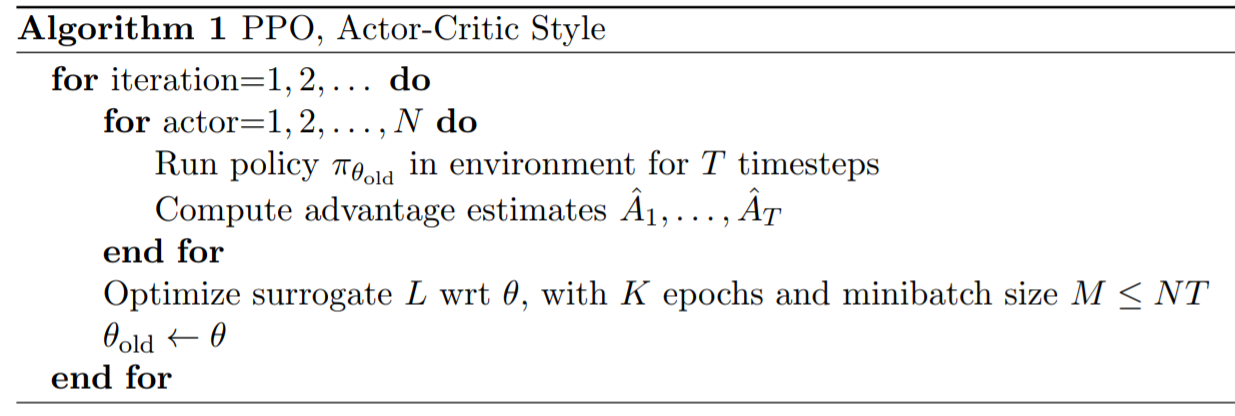

In [15]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from SpiderEnv.SpiderEnv import SpiderEnv

critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
epochs_number = 3000000
batch_size = 256
replay_buffer_size = batch_size
l2_regularization = 0
clip_ratio = 0.2

policy_updates_on_batch = 40
value_updates_on_batch = 40

discount_factor = 0.98
lambda_factor = 0.96

angle_normalization = 135

env_name = 'SpiderEnv'
environments_count = 40

# This code gets action and observation space sizes for 1D tasks
env = SpiderEnv()
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = SpiderEnv()
        env.reset()
        for i in range(int(1500*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std
        self.log_pi = gaussian_loglikelihood(self.action_op, mu, log_std)


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.log_pi_old_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)
        

        # PPO update part
        ratio = tf.exp(self.log_pi - self.log_pi_old_ph)          # pi(a|s) / pi_old(a|s)
        min_adv = tf.where(self.weight_ph > 0, (1 + clip_ratio) * self.weight_ph, (1 - clip_ratio) * self.weight_ph)
        self.loss = -tf.reduce_mean(tf.minimum(ratio * self.weight_ph, min_adv))
        
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.relu)
        l2 = tf.layers.dense(self.state_ph, units=50, activation=tf.nn.relu)

        output_linear = tf.layers.dense(l2, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        
        # Training
        output_log = tf.nn.log_softmax(output_linear)
        self.log_pi = tf.reduce_max(output_log, axis=-1)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)
        self.log_pi_old_ph = tf.placeholder(shape=[None], dtype=tf.float32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        
        
        # PPO update part
        ratio = tf.exp(self.log_pi - self.log_pi_old_ph)          # pi(a|s) / pi_old(a|s)
        min_adv = tf.where(self.weight_ph > 0, (1 + clip_ratio) * self.weight_ph, (1 - clip_ratio) * self.weight_ph)
        self.loss = -tf.reduce_mean(tf.minimum(ratio * self.weight_ph, min_adv))
        
        self.update_op = tf.train.AdamOptimizer(actor_learning_rate).minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)

actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0722 02:39:42.711834 14480 deprecation.py:323] From <ipython-input-4-4811de9db9b3>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0722 02:39:42.717819 14480 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 02:39:43.205545 14480 deprecation.py:323] From <ipython-input-4-4811de9db9b3>:27: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [6]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [7]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

### Advantage estimation formulas

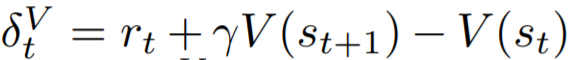

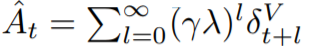

In [8]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [9]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, log_pi, discounted reward-to-go]
    replay_buffer = np.empty((0, 5), np.float32)
    
    # [state, action, reward, log_pi] rollout lists for every environment instance
    rollouts = [np.empty((0, 4)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions, log_pi = sess.run([actor.action_op, actor.log_pi], feed_dict={actor.state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions * angle_normalization)
            observations /= angle_normalization
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards, log_pi)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage
                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)
                
                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 4))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([-0.66666667,  0.05968581, -0.41109065, -0.66666667,  0.34539261,
        0.66666667, -0.57470494, -0.66666667,  0.66666667,  0.30789798,
       -0.09399313, -0.66666667, -0.12764503, -0.66666667, -0.22152326,
        0.14277427, -0.04216525,  0.21309827,  0.00740741,  0.        ]),
        array([ 0.23119548,  0.11682069, -0.4398874 ,  0.3107862 , -0.14534767,
        0.58532256, -0.46270174,  0.7133627 ,  0.87816775,  0.7971769 ,
        0.03782469,  0.5345426 ,  0.8192943 , -0.14963004,  0.01286852,
        1.080811  , -0.3771268 ,  0.7382877 ], dtype=float32),
        23.870909244373863, -15.675423, 47.07306568983082],
       [array([-0.66666667,  0.66666667,  0.22341457, -0.59130187,  0.25778616,
       -0.04824732, -0.41504076,  0.66666667,  0.62001038, -0.07767427,
       -0.07763527,  0.61212995, -0.66666667,  0.23242123, -0.66666667,
       -0.10211136, -0.03114128,  0.45445664,  0.00740741,  0.        ]),
        array([ 0.2506752 , -0.05156307, -0.7439027 ,  0.

## Train agent 

In [10]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [16]:
from tqdm import tqdm_notebook
import pickle

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

saver = tf.train.Saver()


# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

max_value = 1140
actor_loss = 0

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-PPO-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value
        
        with open(f'models/{env_name}-PPO-reward({value}).history', 'wb') as f:
            pickle.dump(history, f)

    # Train actor on minibatch
    for i in range(policy_updates_on_batch):
        _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                                    actor.state_ph: np.array(batch[:, 0].tolist()),
                                                    actor.action_ph: np.array(batch[:, 1].tolist()),
                                                    actor.weight_ph: batch[:, 2],
                                                    actor.log_pi_old_ph: batch[:, 3]})
        if i == 0:
            history['actor_loss'].append(actor_loss)

    for i in range(value_updates_on_batch):
        _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                                    critic.state_ph: np.array(batch[:, 0].tolist()),
                                                    critic.value_ph: batch[:, 4]})
        if i == 0:
            history['critic_loss'].append(critic_loss)

#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    



Charging generators


Model saved in path: ./models/SpiderEnv-PPO-reward-1148.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1163.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1197.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1213.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1239.ckpt


W0722 05:05:21.718742 14480 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Model saved in path: ./models/SpiderEnv-PPO-reward-1245.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1321.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1329.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1349.ckpt
Model saved in path: ./models/SpiderEnv-PPO-reward-1374.ckpt


MujocoException: Unknown warning type Time = 3.8000.Check for NaN in simulation.

Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'SpiderEnv')

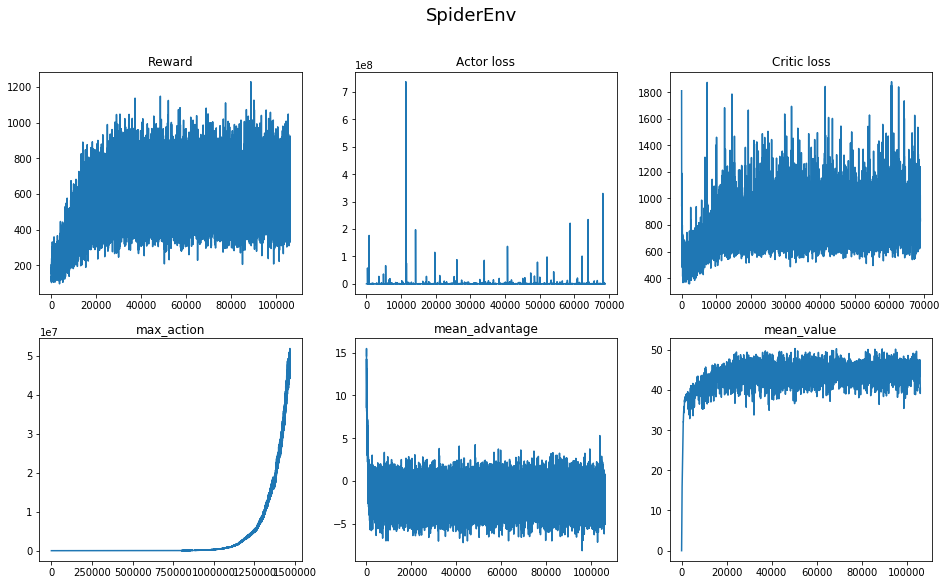

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

#plt.savefig(f'logs/{env_name}')

## Our agent

In [19]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})
    
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0] * angle_normalization)
    observations = observations.astype(np.float32) / angle_normalization

    print('h', rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


Creating window glfw
h 0.9999999999999998 [-14300541.  -14854559.  -21189972.    -799831.   22981642.    4824034.
 -12297330.   20430696.   10631003.    5577230.5   3690538.5 -30690382.
  21643294.   11934019.  -14375836.    6002168.5    590786.9  -4589025.5]
h 0.8891049058987208 [  1851736.6   14056495.    16656593.    15395457.     7378931.5
 -27030752.   -20390898.     4547487.     5514382.5    -624410.94
  14796384.    -6619039.       84132.62    846156.8    1746304.8
  14867119.     6177719.5   -7560773.5 ]
h 0.46765698159669633 [ -9663456.    13987302.   -15904840.     3821664.8  -11176515.
  -8698105.    23682356.     5089713.    -7756501.   -13640891.
   5447764.5     195591.12   1541346.1   -8538253.     -746858.56
   5320368.     7747677.     8471778.  ]
h 0.7760845615516692 [-24050698.    18413666.   -22568902.   -14043539.    20082620.
    194079.44 -16135025.     2390411.8   -4252253.      423133.9
  -3280945.2   19927374.    25948000.    -5034803.    -6109032.
   2357707.

    630471.94    -66301.86  -4759322.  ]
h -0.24480094590038837 [ -1240873.6   6932194.5 -39078308.  -15091854.   -8551619.   -8884902.
   3513420.8  -2617615.5 -17597948.   13018233.   -5288898.5  -3908435.5
   7731239.  -26037566.   14632909.  -13157910.    9364432.   -7375573.5]
h 0.07093209911806286 [  7312009.  -20277738.   10259748.  -12382496.   -7898983.    7480128.5
  12903134.  -10674429.   15433038.   -1715423.2  28909462.    8910879.
 -20042670.    8937129.   15556730.    -646030.3   5005140.5 -32034840. ]
h 0.2950696579890879 [  3819202.8  -6382855.5 -10927174.   -4461297.    4216782.   -3488472.5
   6135376.5  -8435668.   28520662.   14987942.   20961928.   13131847.
   8507885.   20616290.    6315060.5 -12494886.  -12116170.    9251747. ]
h 0.48101542254713137 [ 23766262.   -9216755.    6304161.   16382120.    6974139.    5134317.5
  21523310.  -12202725.  -11788675.    1474051.2   3008617.8   1667874.4
  -9292257.   10685360.    2452547.    7001319.5   6998742.   165617

h 1.5251223578629158 [-16132468.  -19234478.   28114684.  -17778658.   -2851174.5  -3220598.8
 -11679241.  -18091736.  -20281878.   -1713980.2 -10679755.   -1982619.6
 -27278972.    9687810.  -29618780.   18032264.    6384966.    2788539. ]
h 1.4025232512089028 [  7544742.   -12317969.     3104766.    -4601267.5    3487667.8
  22211544.      610821.25  11226794.   -33801104.   -17376176.
   3494254.   -14030290.    18998206.    -9661837.    -4409699.5
   1515984.2   17801188.   -19129378.  ]
h 1.4553260954016543 [ 18604108.    9007221.   14034894.   11484123.  -23458954.   -3451793.5
  18404676.   24899136.   -2706442.8  16033510.   36352056.    3387878.
  -4303167.  -11938996.    7198438.5  -5783799.   -2518256.8 -17521410. ]
h 1.3826559172192718 [-17195216.       64562.09  -5601322.     -171473.84 -11481669.
  23836562.    14246764.    18493588.     5872750.    -9319611.
  -1205324.6  -16379977.   -17976734.     2205543.2  -13526920.
 -28836412.     -277993.47   9576357.  ]
h 1.75007

   3100579.    9476613.  -25411536.   -9247925.    7034596.   -4026097.2]
h 0.10980429497332422 [-25750726.   36048940.  -15005067.    7652933.   19225512.    8088941.5
  -9925431.   -1067736.2 -19002098.   15702078.   11389621.   -6620570.
   2264260.5  -3621646.2  -6054651.    7866332.   -2274914.5  17214910. ]
h 0.03005100136585237 [ 16048957.     6381871.5   17057274.     3960354.5    9317693.
 -27357112.   -17258994.     2430417.     -387329.1    3627597.
   -911414.25   9331827.   -17153216.   -11423893.   -25180858.
  30879470.     1683927.8   24223326.  ]
h 0.0742003560333252 [-22574784.    5191400.  -10696626.   -9238216.    -817086.5   4844389.
   9125804.   -6581003.   -2975617.2 -20278646.  -27647084.  -29178452.
  -2893153.5 -34052000.  -10816146.   11484329.   11835653.   -1974566. ]
h 0.43905671092456333 [-19562820.    6564408.    6296229.5 -17992498.   10174886.   -6922780.
 -17993598.     549352.   -1200551.5  -4864038.5  12589416.   18503464.
  14967417.  -14559082.  

  -7773768.     4821122.5    4462884.5 ]
h 3.5223108166988957 [ -1376406.8  -17747074.     -589023.8    3174576.2   -2293633.2
 -11837876.    13073512.    10977461.    13173717.      502845.03
   9703051.   -17841278.    -5278393.5   -9591669.     7653878.5
  13868308.   -16704192.     7694957.5 ]
h 3.192954465799181 [  1711589.1 -12591409.    3589616.5   1622919.   -3025824.5   7985353.
 -12330630.  -16707960.    9912827.   -3832382.5  17034456.    5222710.
  20140382.   -3770648.8  -4288823.5   4443662.5   9086556.   17156580. ]
h 2.991941653375219 [  2253992.2  14778117.   13581694.    1999633.4  -8182236.    9623625.
 -13666862.   17861318.   -4737835.5 -21018546.   11931441.   -7762358.
   7385646.5 -14857484.  -14846298.   -2751811.5   7633234.5   8676556. ]
h 3.0296472221179758 [-13874557.    -4839959.5    8710329.    19410396.    -4301276.5
    930785.6   -8007104.5   25058352.   -34417810.   -13021879.
  -5600085.5    2523700.5  -49973420.    -8775111.   -21218180.
   3666524.

h 2.484701063526418 [-17919524.   20117384.    8913066.  -22196732.  -12337367.   -9161974.
  -7989143.5   5660010.   16653975.    8852958.  -15105690.   11724995.
 -28638432.  -11216747.    2877884.2  -1353291.1   1926172.4  14639687. ]
h 2.364527367016609 [  2836358.8   26661620.     -373110.53 -23054374.   -10184370.
  18901862.    15675448.     2662432.2  -22208798.     8671685.
  14765532.    -4067472.5   -1387872.9   11374258.     5924967.
 -14086302.     5766782.    22791610.  ]
h 3.0553896744315083 [ 22827976.     9129711.     2975303.5    5191957.    16148560.
  13970118.   -23954602.     8139370.     8563086.    17735714.
   2535159.    17891408.   -11579257.     -728276.56 -16828212.
   7575268.5   -3180447.2   14549466.  ]
h 2.1285841569866895 [ 14262668.     9006190.    -7410708.5   28451074.     2732405.8
   4466002.5    2451403.5   -3264563.5   12829597.   -13339224.
   3845130.8    6025482.5   -1709138.8  -26576650.     8908004.
   -794050.25   1336885.    -4262675.5 ]


   9356360.  -20547888.  -45897070.   -6836915.    4576622.5   9355315. ]
h 0.27560670994983183 [  3211272.5 -29762340.   -5196558.   28421914.   -4584454.    5118533.
 -17815910.    -627600.8   2390159.8  22172462.    1828202.    7460331.
 -16106727.    4433656.   14077105.    1080070.9  10267442.   -2828223.8]
h 0.439374398845469 [-13347669.   13832054.   19225684.   25001780.    4391233.5   6127780.
  11778519.  -30492350.   31236512.   -1284565.1 -10768806.    1573105.6
   9549004.   10264894.   20718902.  -19235104.    9926068.    7899495. ]
h 0.1459625966905983 [ -9500063.   -15618846.    17367706.     2349213.2  -20090350.
   7543792.5   29569400.    -5529055.5  -12487662.      121876.12
 -14966055.    24077198.    -4225420.5   -5689495.     2964498.
  -4784401.    -6538258.5    6688934.  ]
h -0.03586701902023259 [   900579.56 -19001612.   -15591112.    -7432926.5   -8652663.
 -15278562.    -8244276.5   16852054.     8712987.    18419922.
 -21113372.   -15166296.    -7303334.   

  -5719495.    20170850.   -13666201.  ]
h -0.3566956001553956 [-17257340.  -32052356.   -6711323.5   9898675.   -5225820.5  14096892.
  20284756.    7110725.5   9762343.  -15346019.   -1759128.8  13465445.
  16064203.    3932074.    4239509.5   1424443.4  23782850.    8037198. ]
h -0.1784531715014548 [-13202542.  -10803435.  -17595896.  -19869586.  -11162480.  -27312084.
  -5444551.   40355410.   -8968929.    4022444.  -14727129.   -8499188.
   7647750.5  16708451.    2487836.5  -9948002.   -1560226.4   7036835.5]
h 0.07889966446317143 [   568572.8 -27677132.   15578065.    3049038.8   2249317.5  20790628.
   6818756.  -16398045.  -19989168.   -5254702.5 -29202844.    -545603.1
 -24322510.   19715690.  -15813183.  -13656968.  -14674814.  -12061143. ]
h -0.04529061350518493 [-17588752.    28660348.     9854636.   -11625712.    -6723327.5
 -10455631.    -3869955.2   -9922895.     9320307.     9343302.
  10463556.    -3294455.8    4630717.    18688980.       83567.37
   6327296.5   -9102

   7155957.5  15864465.  -17762696.    8914214.    1634038.   -5417611. ]
h 0.054118773219195004 [ 10726889.   23472348.   11741334.   -3702090.2  -1609161.5  -6515434.
   3418301.    5594513.    1729354.6 -15336425.   -8966972.   -7342796.
  18673642.   -7920899.5   2865448.2  24279080.    9100820.    3783491. ]
h 0.10774361212772998 [  7196103.5    7106741.     4551247.5   16516870.    -5103324.5
  -1346436.2   25998526.    -9240350.    16005415.   -15912847.
 -29829578.     -777395.1   17177900.      652152.9    1936026.1
 -13812188.      -77726.49  22531084.  ]
h -0.008140900444359112 [ -8394510.    9846063.   14924043.    8849629.  -13665761.   -4812928.
 -14024739.   39386656.   -7334478.   -6991566.5 -12690532.   -4171099.8
  -4024066.2  24000024.    3684790.2 -25904766.   -3445976.  -14504615. ]
h -0.0707458716217102 [ 14481753.    5221946.5   8390585.    8344570.5    945213.   -6919335.
   2710226.5   9812493.  -35068292.  -31691492.   14155778.  -13956895.
 -10487002.   -9692

h 1.2962452690026331 [ 18026980.    15890853.    -9965312.     -102262.62  22971412.
  10555152.   -10124332.    -2294495.5   18513314.   -17173234.
   9780631.      799601.25   4849567.5   -2568274.5  -30349252.
  15625826.     7026899.   -11203446.  ]
h 1.7996604153416906 [-12633784.   27091822.   -4704383.5  24070042.   -1057431.8  -4649805.
    921259.6   1632162.8  -8758648.  -14616368.    1050950.6  17137576.
  22596400.    6667838.5 -22523338.    5361475.  -32139216.   -2007011.9]
h 1.6720135624791057 [ 20293922.  -16256034.    7401231.   10179138.   17398936.  -14148014.
 -22261780.   -2184899.8 -13640477.   -3112228.8   9923289.    2975345.
 -12392656.  -10794784.   17840672.   -7990370.5   7458885.5  18826362. ]
h 1.177991037655704 [ -1335041.5   -4980797.5   -6763813.    -2075273.5   -5428932.5
 -14003240.     7360929.5   25324210.   -19995086.   -10198845.
  12045078.   -11711123.      577021.44  11699386.     5238079.
  16282157.   -11912745.   -16662716.  ]
h 1.1941805506

 -29139268.    17958266.     -199607.1 ]
h 0.9153457559427292 [  5146790.5     133547.78   5057276.5  -32336942.     6471357.5
  -9692831.    -2235921.5  -10275205.      496258.38 -18764656.
 -12973680.    11105936.   -24888268.     3371848.2  -24493176.
  -7898485.5   17251350.    16786726.  ]
h 1.009180239457885 [ 7.0702515e+06  3.9357075e+05 -1.3102969e+04  1.4953800e+07
 -7.9452470e+06  9.2687931e+05 -1.9200954e+07  1.2215121e+07
 -1.4535838e+07 -1.0937740e+06 -1.9579068e+07 -4.9007430e+06
 -4.1570370e+06 -1.2408301e+07  4.5970585e+06  8.2316365e+06
  3.6841040e+07 -1.5176847e+07]
h 1.1758755408382169 [ 24562404.   27727610.   12937171.  -11554169.    7307373.5   5812152.
 -17642002.   15265993.   -9546135.  -11136424.   39077556.  -12285540.
 -11854734.  -14661225.  -15917571.   -6226615.5 -11881822.  -13160155. ]
h 1.4983795659429213 [-13395437.     -204164.95 -10997315.    17983922.   -20617268.
   8397891.    10549325.     8042262.     -992070.2   -9054539.
 -32358952.     7282

  17870274.   -1642087.8 -28671944.    5309535.5  26799404.   16809408. ]
h 0.3212091066099555 [ -8823402.   12178923.   26130706.    8243165.5  15458382.   -2385458.2
  -5759794.5  25297368.  -14744768.  -14590778.   39903600.   -5152838.5
  -5760404.5 -16214758.  -11079353.  -23894292.   -9511273.   21176176. ]
h -0.007097172063695201 [  6525486.5 -15300694.    9323187.   13381662.   -5245840.    3608464.
 -19894030.     341280.7   5572411.5   3884329.2   4795760.   16718659.
  21806344.   -4201648.   -8299896.   22701340.   10727356.   17187834. ]
h -0.17890180732774597 [ -8002552.    4286834.5 -10278816.   16372377.    7976201.5   1020253.
  -5003732.5 -12957129.  -24704364.   12381786.  -14540312.    8423331.
  -1523589.9 -12209347.   -5087491.  -19445700.    9503800.   -1646403.4]
h -0.5575606093861019 [  2756170.8   10342471.    11172864.   -19820266.    18196482.
 -29601460.   -10759149.    25497106.    -4545520.    -7432867.5
  -8385208.    28301982.   -16367059.    -1039230.0

 -13896830.   24470696.    8588139.   -2922495.5   3215955.2  15624281. ]
h 0.3664623881147111 [  9092836.      4365141.5      252235.22   -7927183.      5757682.5
   5172459.5   -11849714.      3014331.5    16478937.     -2475295.5
  -6374826.     -6811796.      4210672.     13973904.      1993253.
    110753.305  41267724.      9416321.   ]
h 0.7380430248547839 [  2283854.8  -2194366.5  -1967808.9 -30967618.    4725355.    3809364.5
  -9994256.    7131622.5 -31815136.   -5311833.5  10911407.  -10537698.
 -25603440.    7449491.    6607969.5  -6174796.    3713795.5   6512679.5]
h 1.0306948823953268 [ -8685451.  -21406452.    5034211.   -4559392.  -15749129.   -8414881.
   3278574.8   3641382.   10646178.  -26765782.   16505985.    5805829.5
   5772332.   -3033274.2  26633078.    6707173.5  13103345.   10307970. ]
h 0.7209413236582444 [ 18867534.    25385230.   -12312200.     8650262.   -20116512.
  11185277.    20738946.    -2340433.2    6990023.    19699672.
 -25713710.    -9505521.  

 -42991188.  -12575371.    7124841.5 -22238338.   13489500.    4091796.5]
h 0.5673883469058871 [-12138387.  -19906180.  -13239496.  -12142717.   10848142.   11278615.
 -11427764.  -17792220.  -19798098.    2209518.5  22223362.   11674030.
  14601566.    5433906.5  18507118.   -8945191.  -24673676.    4218718.5]
h 0.5356416164498797 [-17842266.    16075577.    -7581907.   -20338374.    28408424.
   5648872.     4742003.5  -14113817.    -7703393.     6028708.
   5176193.5     371848.72  19184354.     5085137.5    3357625.8
  14079148.    -7968890.   -13400777.  ]
h 0.6500295795149384 [  4798851.    17527726.    -7091548.5   13679704.    17112728.
  20082810.     2447373.    17194504.     2859457.5   23935376.
  -4411234.5    4699017.    -6635399.5    6678186.   -30234432.
  21685472.     9133840.      263856.12]
h 0.6740190573768642 [  2079315.  -21078424.  -13439572.  -19191196.   -1827497.   19585050.
 -15241747.   12937041.   -3201022.5   6988186.    8336519.5  -6273577.5
  25237604. 

 -19162298.   -5481674.5  -8524513.   13063493.   10600591.    5636360.5]
h 1.1410228856380604 [ 18790832.  -16671442.  -12899344.  -23640330.    4382828.5   4447432.
  36222604.   -4016233.   -2981053.8  -4993525.5  -5767246.    7053797.5
  11688138.    1880166.8   4619329.    1133988.6  10157190.  -15960181. ]
h 1.1546092816545677 [ -7941605.5   2201688.    6274975.   13095731.   -4296342.5  -4879228.
  -8602291.   -9333789.   24122070.   20381852.   21726396.   -9297053.
 -12430075.   -8842437.  -17115310.  -10895136.   -7299150.   18836480. ]
h 1.2816480694367365 [-43794052.    2588838.   -6425056.5   5306607.5  -4711428.5   3698321.8
  26636700.   -5463549.5 -10277600.  -12922147.   -3220121.2  -1741725.2
  -3722895.    2322744.2  26600622.   17829030.   15297908.    1862951.4]
h 1.2909860328384404 [ 3.2131922e+07 -2.8250352e+06  2.0140562e+07 -1.3913413e+07
 -3.3405642e+07 -1.1874728e+07  6.5901395e+06  2.5964496e+04
  1.3358215e+07 -9.4691920e+06  3.6292945e+06  6.0417330e+06
 -

  2.1668886e+07 -1.0667650e+07]
h 1.3521590086949211 [ 2.6140878e+07  2.3310216e+07 -1.2019294e+07  1.9283716e+07
 -8.7464810e+06  7.3448540e+06 -3.1960898e+06 -1.4021017e+07
 -3.7794762e+06 -1.0852749e+07 -4.0614648e+06 -2.8257480e+06
  1.8753536e+07  1.5983497e+07 -1.5165725e+06 -1.0324988e+07
 -7.3043925e+06 -4.9565967e+03]
h 1.9727755852862763 [  -602325.9    5644599.5   -2795190.5    -239814.78   4150564.2
 -14800225.    21411556.    18213634.    10372242.     -781414.3
  19518168.    26328616.    -6109574.    19245108.    13753540.
    540667.25   1419545.5   10481924.  ]
h 1.8064530875016678 [  4927588.5  -2672809.2 -31629426.  -17663504.   -4152462.5  12364087.
  15990451.  -10623099.  -10640090.   38627840.  -10665215.   14111663.
  21523902.    9784769.   -1163323.1  -3568128.8  26998570.   -3658793.8]
h 1.8150427610808286 [  2017754.9   -2192710.8   17736170.   -10910273.    -8265884.5
 -18378424.    -1656201.2   10547534.     8956444.   -11903820.
  10228280.    -7121631.5 

  -3761017.8  -11356411.     1931816.2 ]
h 2.0173937765246626 [-25406816.      593423.06   5022143.    19114964.    28778964.
   5984653.   -26003246.    18292054.    -3402150.5    3798695.
  13415496.    29697734.     9476930.   -26182530.    34226190.
  -8291950.5  -12470713.   -29347796.  ]
h 1.7856653843082393 [  4603941.    10171645.     2558127.8     753835.25 -16434068.
   8571541.   -11462718.    11313400.    -2731632.    -4027268.
  40579460.    -7380427.     7656724.    15587865.   -12391671.
  14516778.    -5760375.    14529674.  ]
h 2.0467478007034035 [  9152893.    16929252.   -11179667.    16128590.    -6082599.
  10245539.     5327016.5  -18927290.    -3585034.5  -12786351.
    147841.39  -4504287.5   10154672.    23821388.     9555474.
  20869870.     8251124.   -14905348.  ]
h 2.3654568333750676 [  9309410.   25430016.   12561088.   14015156.    3019041.2   3050222.5
 -34131396.    -877941.2  11119082.    3605173.5  -3328968.5  23204300.
  25324406.   31250132.   -3538

  12857466.     -710450.44  -4121270.2 ]
h 1.9071980464917964 [ -1647653.8    -3297107.5     -444035.7     -900369.5     5992816.
  18274616.    -19052436.      3827750.8     9743691.      6760502.
   6049185.5    -8153115.     -2163836.       -41483.293   6267911.
 -11307547.    -12745213.      4458660.5  ]
h 1.640895323087025 [ 13537584.   -8241218.  -16701488.  -23469388.   10824178.   20033562.
 -11557349.    -275496.3   2842798.8   8557647.   15563116.   11814721.
 -16126123.  -27133494.  -12275215.  -11348668.   -8275323.5  19640996. ]
h 1.5508688043216141 [ 13387269.     3502777.8    8701965.    11188934.     8957610.
  -6313548.5   -1044846.56 -20673568.    -3177952.5    6153064.
  23661210.    -6355898.5    4075425.2   28885300.   -14594996.
 -31101014.   -27540454.   -11154839.  ]
h 1.1779362329975207 [ 15054163.   -5446081.5   9458737.   -6262754.5  10417024.   16975942.
 -10500579.   15870208.   12633457.  -14599641.     539084.2  15317411.
   7459573.5  14897118.    237876

  23224468.    -1936570.6   -3289000.  ]
h 0.2948537785593952 [  6775393.    3860190.   16936078.    7289069.    2707216.5  18716518.
 -17019330.    4165203.5   1416106.  -15406428.    6345714.   23348482.
  -9040141.   14077564.   -4443879.5  -6356838.  -12955666.   -1012137.5]
h 0.21024726549971273 [ 15954871.     6883023.     4705568.5   -9335590.   -29020902.
 -16258407.   -10611208.    -1739641.5  -18801724.     6621466.5
  -3030502.2  -10159256.    -8986817.    -2877059.8      99919.34
   3221430.2   -9583271.    19884754.  ]
h 1.11545762165631 [ 10242912.   -4357905.5  -5696249.5   4363714.5   1191850.5 -11950976.
 -27821508.   -4432124.   -8862933.  -13566504.   20589352.   -8146149.
  19180520.  -10846866.   -3499079.8  11005746.   13203516.    8997051. ]
h 1.0092856172800435 [ -3268967.2   10617997.    18704252.     6749356.    12818999.
  -8940430.    -4958282.5   16924940.     5644520.    16133657.
 -13428125.   -13454445.   -16625243.    -6746081.5    1880007.2
  15858262.

  -8529896.     8094699.    -4488385.  ]
h 1.2872954831990293 [  3990735.2    4945662.    12200924.    11560135.    11969287.
  -4055804.     3272386.8    2341208.2    4031652.8     302673.16
  23845758.   -13854494.    11665378.     8756475.    -1599331.4
  -4286143.5    4889956.5   18533374.  ]
h 1.8320032450742607 [-3832136.    9426703.   34222876.    -733996.6  33784332.    9675378.
  3228156.   22075032.     -71827.93   635984.94  1906335.2  20381516.
 -1081496.   -1149326.8  -5330227.   -5804327.   31489580.    3897256.  ]
h 2.017921302061329 [ -2188738.   -33580236.    33838764.      790398.8  -17706690.
    153720.84 -16596387.    28192898.     9678509.    -1968779.9
  19216548.     7241383.5    6023768.5   13655753.    28720604.
 -23006584.    -5793776.    11698234.  ]
h 1.9569687625649599 [  1985181.9    -764000.56   4446693.5   15929044.    -8003480.5
 -12688732.     3566329.     2932950.2    5897844.     3921526.
  17170744.     2940060.8   -8236152.   -12326149.    1284504

 -1.4670079e+06 -1.1561032e+07]
h 0.7358278904043394 [  3073174.8 -22411346.   -5684334.5  29521620.   -1707532.1  -4043931.2
    726414.1 -16465285.   32573846.   -5456886.    8891262.  -10781798.
    862120.1  12147220.   -3401613.2   1776813.9 -10534846.    2615622.2]
h 0.7004858216609743 [ 18500082.   -3043491.2 -32866406.   29100332.  -10959862.   20465472.
  38951050.  -29818920.   -3532348.   -5917362.5  -7227660.    6765191.5
   5612297.5  -8314476.   16275835.  -18232160.   17208372.   -9075897. ]
h 0.8829712631817288 [  6167568.    1155399.2 -13916305.   11149036.  -18745368.   11611620.
   4007169.2  -2235447.2  -4431699.5  -2010374.8  -2189571.  -27796016.
 -12563280.  -13156969.    4829999.5 -11242277.   -4468568.5 -19632448. ]
h 1.0540543918761405 [ -6419321.5   -7504047.5   -1214178.     -881206.4    4307738.5
 -16043990.   -10069708.     -365018.88  -2715657.8   -9459664.
 -13062828.    -7911242.    14783088.   -12773621.    -3688633.8
    606810.75 -19488844.     95285

h 0.5373034214322001 [ -1751938.1  -17047628.     -575867.8   -2652909.     -245579.22
 -14008371.     4344475.       92656.68  -3859729.2  -12110755.
  22425796.   -21627616.    -7738113.     1267129.8   24029070.
 -20040626.    15243762.    -2473689.2 ]
h 0.4926514927971566 [  3796466.2 -26417630.   11678393.   20108008.  -24994738.    8015317.5
   6987604.    9677460.  -10796455.    1245428.2 -19437724.  -12182572.
  -8834092.   -1438878.2   -129977.2  -3300678.    4483244.5  -5434980. ]
h 0.5188647359855606 [  9405305.   -10850041.      346319.94   4693846.      663194.4
  11539101.     6955921.     4498540.    11608903.     -806175.1
   1842623.8    -997139.9   -3387985.    -6700757.5  -11728788.
 -24679728.   -10399093.    -6106345.  ]
h 0.3736921238053732 [-41420036.   15167822.   -5441177.5  -3408294.2  -4765038.5  -1402537.6
 -14568090.   17906826.   18833068.   16291281.   17325204.  -16080974.
   7440943.5  -9445474.     627024.3  -1373509.8   -335178.3 -13661140. ]
h 0.5243

   6633685.5   3953170.   -2968458.    7908600.5  17101652.   -7714229.5]
h -2.678715607210323 [ 18713046.   -22650002.     3526453.5  -13994490.    31031314.
  -7097203.    20753442.    13785283.      275484.8   21904540.
 -11508504.   -39968012.     6753929.    -6851830.5   11446883.
   6670877.5     238806.38 -12438637.  ]
h -2.6553932700534064 [  1094431.2 -13726296.   -8447170.    4182442.   -4158848.    3489183.2
   2096384.6  11704517.    2583028.5  -6489215.5  15496889.   -9538753.
  32132268.  -12793994.   20481196.   -3320804.2  32175606.  -19768024. ]
h -2.434772455029406 [ 10348952.   16856990.   14746556.   -6285436.5 -12282709.  -10157880.
 -18492920.    8760790.    7395832.5  -2160735.   14232356.    7219756.5
  16011052.   -2240609.    7157942.5   3496380.   17337954.  -23110852. ]
h -2.202107955414972 [  9178584.   -3961481.5 -19152524.  -10455744.   16205466.   19267076.
  14485577.   -9628040.  -19504522.  -16459420.    -402624.6 -22352294.
   5921705.   -6545761.5  

 -14387604.   -6373268.5  -6749664.    -886917.3 -14437526.   36113692. ]
h 0.19171055138864168 [-12082889.  -21456394.   -7305435.5 -11867872.  -14285424.   -8216425.5
  16843624.    9702969.   -7145912.5  10950520.    5350553.5  -5254508.5
 -21277188.  -16008192.  -12487997.  -10453074.  -11171636.   -4906449.5]
h 0.14868450720936088 [ 13352453.      435935.28  17644138.    11861391.     -437224.56
   -182876.44  -8696702.    15965599.   -13604845.   -19835954.
  -2772051.    -1186061.2   -1564105.6   10321350.    -3113443.2
  19254626.   -16754364.     2051635.4 ]
h 0.27673136281502764 [ 14750475.    21048704.    -1215170.4    -867940.7   24589214.
 -25835878.     5954110.5    4532948.     9557083.     2892911.8
  16000407.   -24163026.     4236138.    23018850.    26476434.
  -7622766.     9786119.      176011.61]
h 0.48791287234743397 [ -5210632.   -19162646.   -19387514.    -6909175.    -7556717.5
  30054012.   -15373801.     9731619.   -17761536.     2006263.1
    503421.97  -67

  -2464572.     6849696.   -13943223.  ]
h 0.8053308163330714 [ -1839268.  -17850998.  -24740778.    6548817.5  -9406197.   -5911799.
 -10208221.   -1557997.9  24395934.   13544800.    8338643.    7202063.
 -24854682.   33891420.   -1945664.4   7621891.5   1333585.9  18735716. ]
h 0.7196602861888672 [ 2.0340076e+06  1.1476833e+07 -1.3652153e+07  1.0236992e+07
 -3.0200958e+07  2.9609934e+07  1.5465464e+07 -4.0434932e+06
  1.0342799e+06  1.4830437e+07  1.0542559e+07  1.5301146e+06
 -1.8534012e+07  2.3888783e+04 -5.0352200e+06  1.3173895e+07
  5.8967369e+05 -1.9265506e+06]
h 1.1074493517406807 [ 15253821.   11172351.    5712944.5  -6563032.   23588994.  -18200478.
  21570844.  -21194328.   -7898169.    -301558.3  23808758.   17904180.
  24930974.  -23417984.    9687550.   13545588.   -6424532.5   9936768. ]
h 0.978164508185106 [-33394188.    -7616297.5    4474238.5  -15551021.     8283129.
  -5284989.     9555715.   -16245674.   -16964060.   -35384760.
   -930473.2  -14712946.     -171979

   5833065.   16060525.    7826048.5 -21860780.  -14720446.   -6795569. ]
h 3.871840626132306 [-10128505.      -69364.22 -21155162.   -31394460.   -16723585.
 -21862002.    -3555585.8   30087178.    16822120.   -22285290.
  12846400.    18731162.    22528468.   -24091752.   -16841588.
   -388962.34   4736106.5  -17626906.  ]
h 4.549567534763466 [  -172712.61   6011371.5    5089970.    -3907929.   -19142894.
   4328591.    23459926.    25460016.   -30843432.   -15444931.
  -5340056.5   23409912.    11872331.    14148814.      171307.67
  -6591684.5   16747316.     4556548.5 ]
h 3.237690973575436 [ 10895375.    24767566.    15923374.     5082049.     6733896.
  13981318.    -5710954.   -13285865.    -8580218.     8914363.
  -3327959.     -836521.9     514088.03  23378914.    -7293401.5
  14646173.    14173099.    -8122392.5 ]
Done
h 0.9999999999999998 [-17057622.     2743053.5    -745482.56  34829068.    33761068.
  -5271493.5   -3295290.8  -26333872.    -9596054.    17246096.
   3798545

  -4794119.    -29906254.     13246780.   ]
h 0.48171783543005364 [ -9450354.  -26535544.  -10329256.  -10476184.   -2044389.4  -4330965.5
   5845018.5 -20551812.  -17175476.   -2184746.2  22409606.    3804197.8
  -2527602.   -9746938.  -12386974.   19633488.  -10243477.    8714522. ]
h 0.9980476906820265 [ 13008186.   13976985.   13022065.   33286956.  -18516448.  -13230496.
   -179684.1  -7424217.  -10349876.  -18774914.  -14224151.   11870688.
  42806156.    6705684.   -6919913.    6694485.   17968728.    7570032. ]
h 1.1237191218849842 [ -6417055.5  -6362061.5   3278907.8  -6219834.5   1309576.8  21479702.
 -20128864.    1309083.9  -3343182.2  -6506532.  -17071038.   12234835.
  24779720.   -1639743.  -13813474.    4106497.5 -12053117.   21624458. ]
h 1.146756880961836 [-19630828.    2432904.5 -12010114.   -5523164.   -1394052.4   3053873.5
 -20927656.  -24255486.  -20754674.   31154286.    6680232.5 -15498845.
   6742948.5   1225089.1 -19934086.   -7699339.5  -8162857.5 -11481330.

 -16787018.   -5718502.5   2752228.5 -15559353.    6220439.5  -1902214.8]
h 0.9452144926347513 [ -9057823.   -10606942.   -20736664.    22833566.      948914.25
 -18932742.    -8583944.    -1741777.4  -10078806.      204805.11
  -4381775.     3655761.5   -1067604.1    6771124.     8781484.
  -1771973.     7697689.5   -4978037.5 ]
h 1.1579790685104498 [ -3441139.8 -10095956.    4104628.2  -5955430.    7908804.5  29423104.
 -14076981.   -1113243.5   4982207.5  21070192.    9003200.  -10509911.
 -10921076.    1381450.   16065929.   -7626318.5 -10555968.   11095836. ]
h 1.2888564894576104 [ -8115400.    -1315512.      222583.56  -8326778.5   12352555.
  -8715756.    -4376175.    13586093.   -13848654.    11601538.
  -1153869.5  -21543220.    21179512.    -2909353.2  -10863785.
  -7209923.5    5883767.     8075707.  ]
h 0.6304068671606411 [ -3727691.2   -3958352.8    5976645.     1166390.4    5538897.5
   2628182.   -25636456.      711557.56  20690850.   -15945966.
 -20147204.    -7649874.5

  -5879941.5 -36600144.    6262281.   16239284.   -1683297.1   7022859. ]
h 0.8011098243161296 [ -1597168.4   2846792.2 -11262588.    -316858.4  -2741877.5   4297104.5
   3748647.5 -23542210.   23063486.    8333792.5 -10733539.    4211480.5
  14246016.  -16107559.   13246572.    5168740.   15111321.  -23078176. ]
h 1.0564217192217733 [  2610142.   19426280.   -3200137.    6386831.   -8425851.   12838295.
   7166331.5  -2399479.2   6621142.   11541198.   20562464.    1911717.8
 -26716944.    6324264.5   1095272.8   9048309.  -17132696.    6653129.5]
h 0.970304477897455 [-18322550.   -6974501.    9882322.  -16947604.   -5488943.5   6361549.
   8086231.   13411018.    -736994.   -5584188.   20321004.   15695581.
  -5147911.    6525413.  -34545908.    3069548.8  18143918.   -1110823.1]
h 0.6821999267313728 [-14727440.    2887379.5   3609936.5  -5334679.   22297548.   18237682.
  -7534469.   -9351470.    8840590.   -6845912.5    701360.  -21010810.
   1103432.5  14838554.   27396808.  -2256

NameError: name 'exit' is not defined

## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/LunarLanderContinuous-v2-reward-96.ckpt")

In [ ]:
d = 20
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], d)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], d)
q_table = np.zeros((d, d))

for i in range(len(x)):
    for j in range(len(y)):
        q_table[i][j] = sess.run(critic.value_op, feed_dict={critic.state_ph: [[x[i], y[j]]]})[0]


In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = q_table


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)